In [1]:
import numpy as np
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt

# LOAD DATA

In [2]:
# Create dataset: join the info from the 2 channels, change the channel names to 0 and 1.

def create_dataset(dataframe1, dataframe2):
    # Load both pandas: 
    
    df1 = pd.read_csv(dataframe1)
    df2 = pd.read_csv(dataframe2)

    # Join the two pandas
    final_df = pd.concat([df1, df2], join="inner")

    # Change the channel name to 0 or 1 (binary classifier):
    final_df["channel"] = np.where(final_df["channel"] == "#loltyler1", 0, 1)
    
    # Drop these 2 columns since they don't provice much information for our problem:

    final_df.drop("datetime", axis=1, inplace=True)
    final_df.drop("Unnamed: 0", axis=1, inplace=True)
    
    return final_df

In [3]:
final_df = create_dataset(r"/kaggle/input/finaldataset/datasetchess.csv", r"/kaggle/input/finaldataset/datasetloltyler1.csv")
print(final_df.shape)

(10005, 3)


In [4]:
final_df

,username,channel,message
0,milanista_naqid,1,MUTED @GothamChess
1,lightshad3z,1,try the g6 setup?
2,lawff_,1,lol
3,notjag05,1,Muted
4,slipperysnake321,1,Who is this Beaker-looking nerd?
...,...,...,...
5000,boobyoobyooby,0,@xaladnaia123 learn english
5001,marifer_cr,0,nice kata EHEHE
5002,ibasicks,0,KEKW
5003,cap2567,0,Pog KR kat


# LOWERCASE

In [5]:
# Notice that we want Sleep = SLEEP = SlEEp = sleeP ETC
final_df["message"] = final_df["message"].str.lower()

# REMOVE RAW IF ANY NAN IN IT

In [6]:
final_df  = final_df.dropna()
print(final_df.shape)

(9998, 3)


In [7]:
import string

In [8]:
import nltk

# REMOVE STOPWORDS AND PUNCTUATION SYMBOLS

In [9]:
# Import stopwords with scikit-learn
# Remove words like: can, could, will, been, would...
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS
stop_words = list(stop) + list(string.punctuation )

def clean_text ( text ) :
    words_List = nltk.word_tokenize(text)
    final_list = [ elto for elto in words_List if elto not in stop_words ]
    return (" ". join ( final_list ))

In [10]:
final_df["message"] = final_df["message"].apply( clean_text )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
final_df

,username,channel,message
0,milanista_naqid,1,muted gothamchess
1,lightshad3z,1,try g6 setup
2,lawff_,1,lol
3,notjag05,1,muted
4,slipperysnake321,1,beaker-looking nerd
...,...,...,...
5000,boobyoobyooby,0,xaladnaia123 learn english
5001,marifer_cr,0,nice kata ehehe
5002,ibasicks,0,kekw
5003,cap2567,0,pog kr kat


In [12]:
final_df["message"] = final_df["message"] + " " + final_df["username"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
final_df

,username,channel,message
0,milanista_naqid,1,muted gothamchess milanista_naqid
1,lightshad3z,1,try g6 setup lightshad3z
2,lawff_,1,lol lawff_
3,notjag05,1,muted notjag05
4,slipperysnake321,1,beaker-looking nerd slipperysnake321
...,...,...,...
5000,boobyoobyooby,0,xaladnaia123 learn english boobyoobyooby
5001,marifer_cr,0,nice kata ehehe marifer_cr
5002,ibasicks,0,kekw ibasicks
5003,cap2567,0,pog kr kat cap2567


# STEMMING

In [14]:
# Stemming is the process of reducing inflection in words (e.g. connection, connects, connected) to their root form (e.g. connect). 
# Use English stemmer.
stemmer = SnowballStemmer("english")

final_df['message'] = final_df['message'].astype(str).str.split()
final_df['message'] = final_df['message'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.

print(final_df.shape)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(9998, 3)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# DROP THE ROWS THAT DON'T HAVE ANY MESSAGE! 

In [15]:
indexes_to_remove = []
for i, element in enumerate(final_df["message"]):
    if len(element) == 0:
        indexes_to_remove.append(i)
        
# We want to drop the rows that are in this index!  
print(indexes_to_remove)

[]


In [16]:
final_df = final_df.drop(final_df.index[indexes_to_remove])

In [17]:
final_df.shape

(9998, 3)

# SHOW A WORD CLOUD FOR EACH CHANNEL (MOST COMMON WORDS)

In [18]:
from wordcloud import WordCloud 


# Select the messages for each class
df1_clean = final_df[final_df["channel"] == 0]
df2_clean = final_df[final_df["channel"] == 1]

# Create string of the messages to insert it into the wordcloud
df1_messages_to_string = []
for element in df1_clean["message"]:
    for i in element:
        df1_messages_to_string.append(i)
        
df2_messages_to_string = []
for element in df2_clean["message"]:
    for i in element:
        df2_messages_to_string.append(i)
        
word_cloud_df1 = WordCloud(collocations = False, background_color = 'white').generate(" ".join(df1_messages_to_string))
word_cloud_df2 = WordCloud(collocations = False, background_color = 'white').generate(" ".join(df2_messages_to_string))

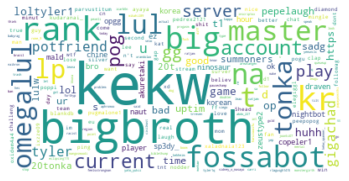

In [19]:
# Display the generated image:
plt.imshow(word_cloud_df1, interpolation='bilinear' )
plt.axis("off")
plt.show()

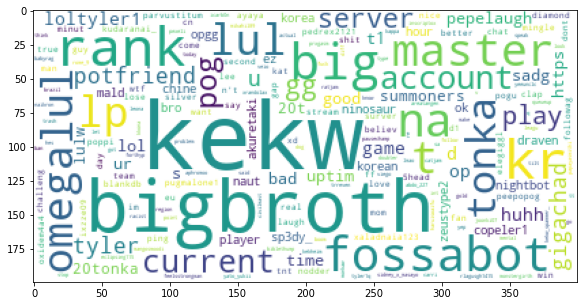

In [20]:
from matplotlib import pyplot as plt

plt.figure(figsize = (18,5))
plt.imshow(word_cloud_df1 )

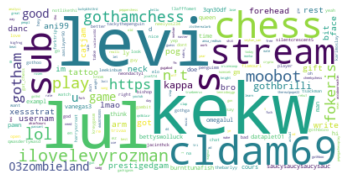

In [21]:
# Display the generated image:
plt.imshow(word_cloud_df2, interpolation='bilinear')
plt.axis("off")
plt.show()

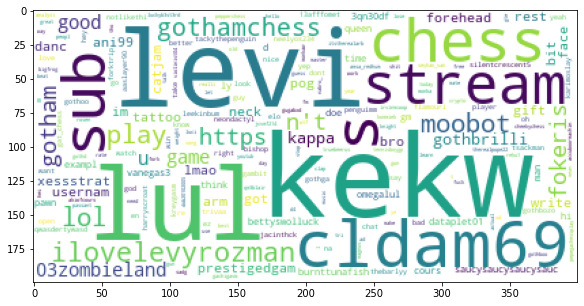

In [22]:
from matplotlib import pyplot as plt

plt.figure(figsize = (18,5))
plt.imshow(word_cloud_df2 )

In [23]:
# Transform to string

def list_to_string(text ) :
    text = " ".join(text)
    return text

final_df["message"] = [list_to_string(elto) for elto in final_df["message"]]

In [24]:
final_df

,username,channel,message
0,milanista_naqid,1,mute gothamchess milanista_naqid
1,lightshad3z,1,tri g6 setup lightshad3z
2,lawff_,1,lol lawff_
3,notjag05,1,mute notjag05
4,slipperysnake321,1,beaker-look nerd slipperysnake321
...,...,...,...
5000,boobyoobyooby,0,xaladnaia123 learn english boobyoobyoobi
5001,marifer_cr,0,nice kata eheh marifer_cr
5002,ibasicks,0,kekw ibasick
5003,cap2567,0,pog kr kat cap2567


# DIVIDE DATA: TRAIN & SPLIT

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_df["message"], final_df["channel"], test_size=0.2, random_state=42)

# NAIVE BAYES CLASSIFIER

In [26]:
# ### SKLEARN MULTINOMIAL NAIVE BAYES

from sklearn . naive_bayes import MultinomialNB
from sklearn import metrics
import sklearn . feature_extraction . text as txt
from sklearn . pipeline import Pipeline
from sklearn . feature_extraction . text import TfidfVectorizer

In [27]:
# Equivalent to CountVectorizer followed by TfidfTransformer .
tf = TfidfVectorizer()

In [28]:
X_train

3970                            5head smile_vwv
1561                     gg gotham.. 13afffomet
1670                     gm chat itsbaileytoyou
4347                         communism ez kuel0
3103                                   paytonbp
                         ...                   
736       play real adc like twitch kekw imshad
193                                xd lpegue_lo
392                                 sadg zandew
860                        premov noob tsackman
2273    atleast say eu na joke region midoropen
Name: message, Length: 7998, dtype: object

In [29]:
# Return a document - term matrix
vectors = tf.fit_transform(X_train)
vectors_test = tf.transform(X_test)
print (vectors.shape , vectors_test.shape)

(7998, 6685) (2000, 6685)


In [30]:
# train model
clfNB = MultinomialNB ( alpha =0.01)
clfNB.fit(vectors , y_train)

MultinomialNB(alpha=0.01)

In [31]:
# test scores
pred = clfNB.predict(vectors_test)

In [32]:
pred

array([1, 1, 1, ..., 0, 1, 0])

In [33]:
clfNB.score(vectors_test , y_test)

0.969

In [34]:
mat = metrics.confusion_matrix (y_test , pred )

In [35]:
mat

array([[939,  29],
       [ 33, 999]])

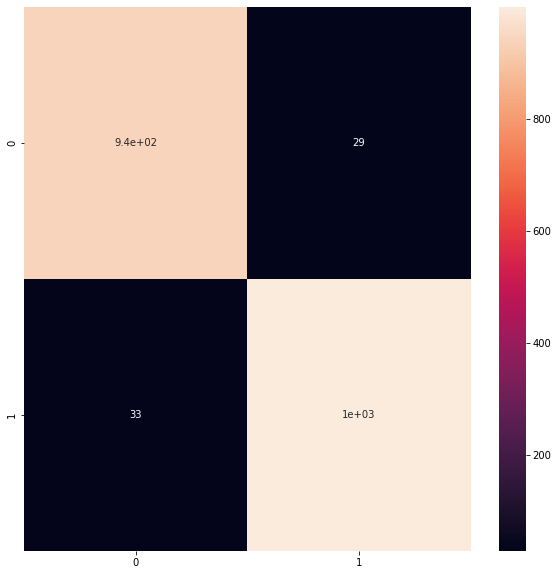

In [36]:
import seaborn as sns

df_cm = pd.DataFrame( mat)
plt.figure(figsize =(10 ,10) )
sns.heatmap(df_cm, annot = True)
plt.show ()

In [37]:
clfNB.score(vectors, y_train)

0.9997499374843711

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       968
           1       0.97      0.97      0.97      1032

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



#  SUPPORT VECTOR MACHINE : SVM

In [39]:
from sklearn.svm import SVC

In [40]:
svm_model_linear = SVC(kernel='poly',C=1,degree = 2).fit(vectors , y_train)
svm_predictions = svm_model_linear.predict(vectors_test )

In [41]:
cm_svm = metrics.confusion_matrix(y_test , svm_predictions)

In [42]:
cm_svm

array([[ 929,   39],
       [  26, 1006]])

In [43]:
print (classification_report( y_test , svm_predictions ) )

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       968
           1       0.96      0.97      0.97      1032

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



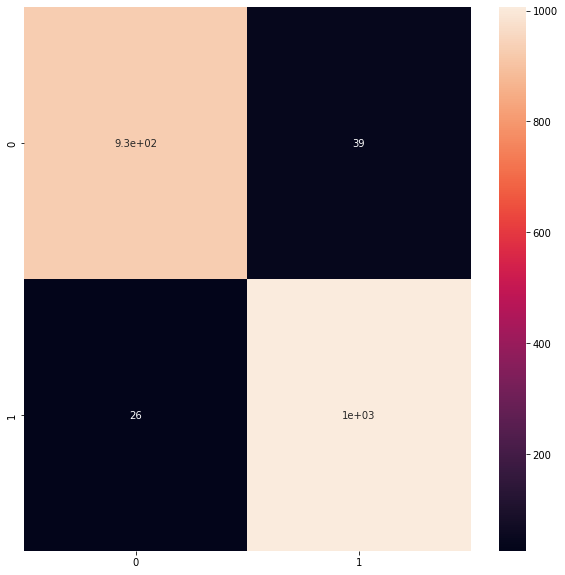

In [44]:
import seaborn as sns

df_cm = pd.DataFrame(cm_svm)
plt.figure(figsize =(10 ,10) )
sns.heatmap(df_cm, annot = True)
plt.show ()

# LOGISTIC REGRESSION

In [45]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier_log = LogisticRegression()

In [46]:
clf = LogisticRegression(random_state=0).fit(vectors , y_train)
lr_predictions = clf.predict(vectors_test )

In [47]:
cm_lr = metrics.confusion_matrix(y_test , lr_predictions)


In [48]:
cm_lr

array([[912,  56],
       [ 43, 989]])

In [49]:
print (classification_report( y_test ,lr_predictions) )

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       968
           1       0.95      0.96      0.95      1032

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



# GradientBoostingClassifier

In [50]:

from sklearn.ensemble import GradientBoostingClassifier

In [51]:
clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(vectors , y_train)
clf_gb.score(vectors, y_train)

0.7855713928482121

In [52]:
clf_predictions_gb = clf_gb.predict(vectors_test )

In [53]:
cm_gb = metrics.confusion_matrix(y_test , clf_predictions_gb)


In [54]:
cm_gb

array([[607, 361],
       [ 47, 985]])

In [55]:
print (classification_report( y_test ,clf_predictions_gb) )

              precision    recall  f1-score   support

           0       0.93      0.63      0.75       968
           1       0.73      0.95      0.83      1032

    accuracy                           0.80      2000
   macro avg       0.83      0.79      0.79      2000
weighted avg       0.83      0.80      0.79      2000

